[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.sandbox.google.com/github/kornia/tutorials/blob/master/source/data_augmentation_sequential.ipynb)

# Augmentation Sequential

In this tutorial we will show how we can quickly perform **data augmentation for various tasks** using the features provided by the `kornia.augmentation.AugmentationSequential` API.

## Install and get data

We install Kornia and some dependencies, and download a simple data sample

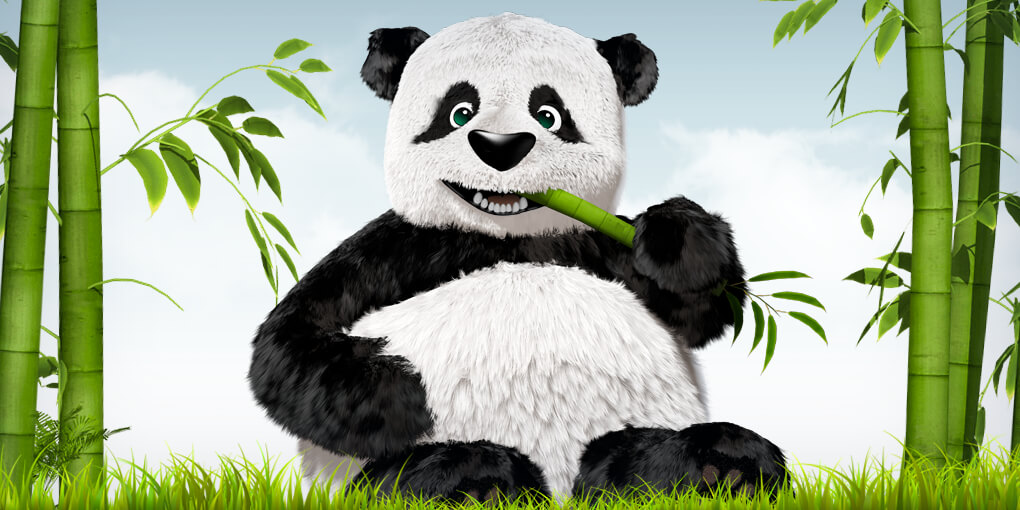

In [1]:
from PIL import Image
import requests
from io import BytesIO
import torch
import cv2
import numpy as np
from torchvision.transforms import transforms

from kornia import augmentation as K
from kornia.augmentation.container.augmentation_seqential import AugmentationSequential
from kornia.geometry import bbox_to_mask


to_tensor = transforms.ToTensor()
to_pil = transforms.ToPILImage()

def tensor_pre_transform_wrapper(input: torch.Tensor):
    """ A wrapper that tried to reproduce the actual output from:
        - transforms.ToPILImage()
        - transforms.ToTensor()
        For each image, simply (img * 255).int() // 255
    """
    return torch.round(input * 255).to(torch.uint8) / 255.


def plot_resulting_image(img, bbox, keypoints, mask):
    img = img * mask
    img_draw = cv2.polylines(np.array(to_pil(img)), bbox.numpy(), isClosed=True, color=(255, 0, 0))
    for k in keypoints[0]:
        img_draw = cv2.circle(img_draw, tuple(k.numpy()[:2]), radius=6, color=(255, 0, 0), thickness=-1)
    return img_draw

response = requests.get("https://tinypng.com/images/social/website.jpg")
img = Image.open(BytesIO(response.content))
img_tensor = to_tensor(img)
img

## Define Augmentation Sequential and Different Labels

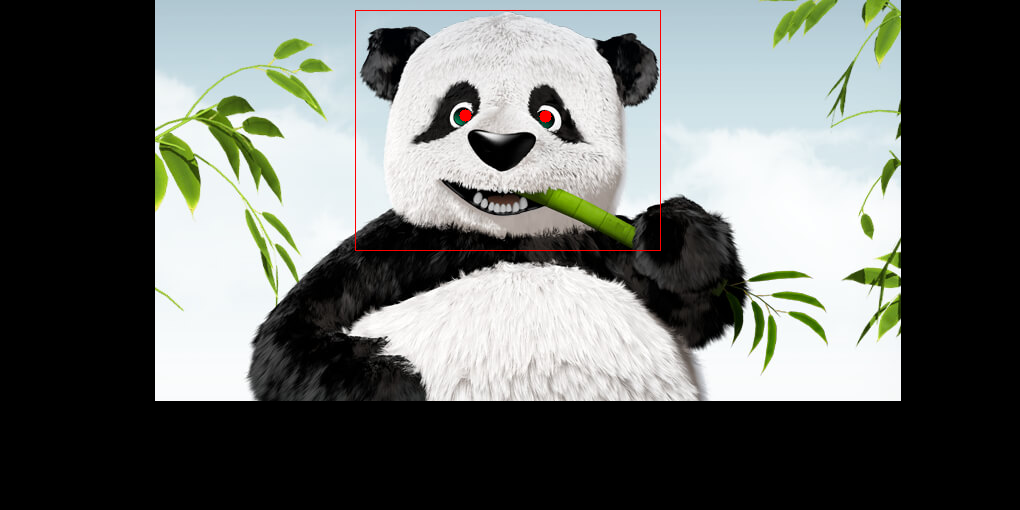

In [7]:
aug_list = AugmentationSequential([
        K.ColorJitter(0.1, 0.1, 0.1, 0.1, p=1.0),
        K.RandomAffine(360, [0.1, 0.1], [0.7, 1.2], [30., 50.], p=1.0),
        K.RandomPerspective(0.5, p=1.0),
    ],
    input_types=["input", "bbox", "keypoints", "mask"],
    return_transform=False,
    same_on_batch=False,
)

bbox = torch.tensor([[[355,10],[660,10],[660,250],[355,250]]])
keypoints = torch.tensor([[[465, 115], [545, 116]]])
mask = bbox_to_mask(torch.tensor([[[155,0],[900,0],[900,400],[155,400]]]), *img.size).float()

Image.fromarray(plot_resulting_image(img_tensor, bbox, keypoints, mask))

## Forward Compuatations

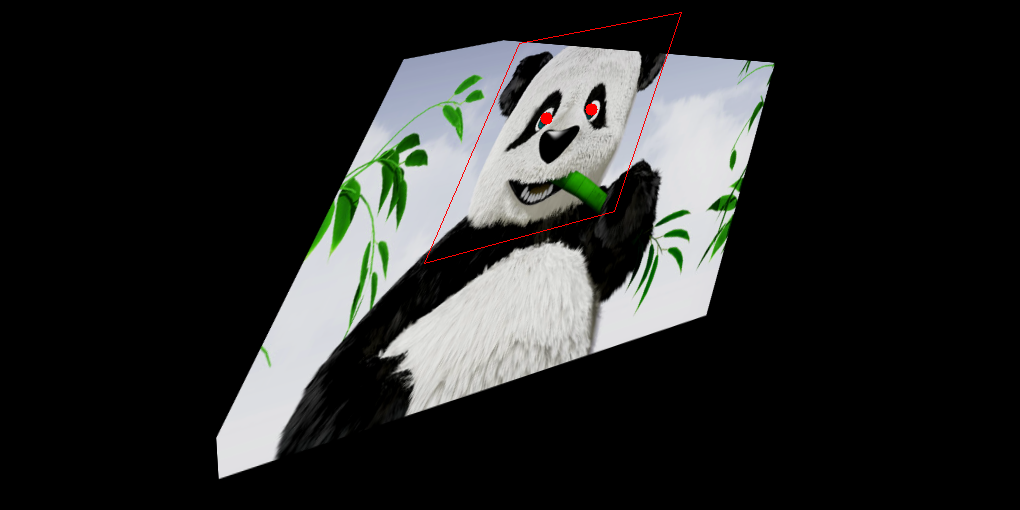

In [8]:
out_tensor = aug_list(img_tensor, bbox.float(), keypoints.float(), mask)
Image.fromarray(plot_resulting_image(
    out_tensor[0][0],
    out_tensor[1].int(),
    out_tensor[2].int(),
    out_tensor[3][0],
))

## Inverse Transformations

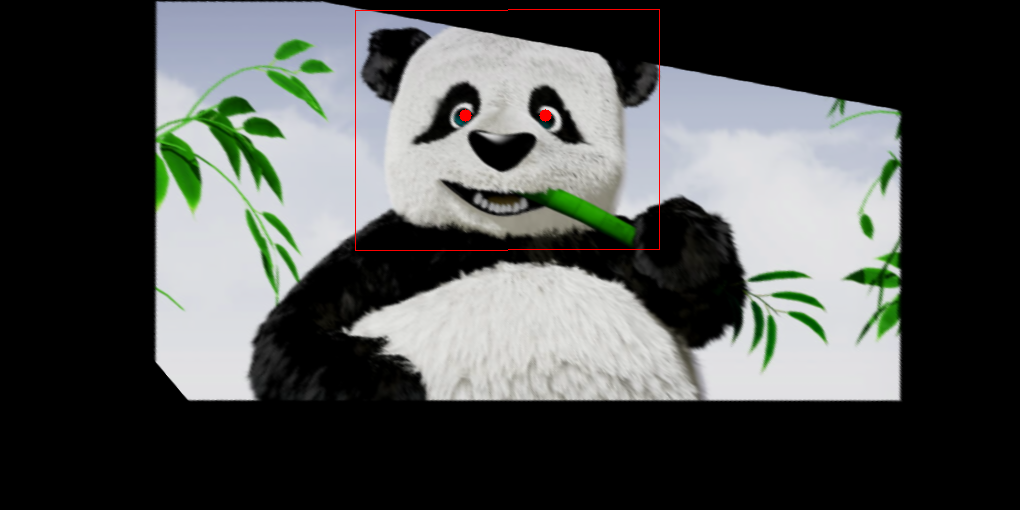

In [9]:
out_tensor_inv = aug_list.inverse(*out_tensor)
Image.fromarray(plot_resulting_image(
    out_tensor_inv[0][0],
    out_tensor_inv[1].int(),
    out_tensor_inv[2].int(),
    out_tensor_inv[3][0],
))